# Module 10 - Regression Algorithms - Ridge & LASSO Regression with Polynomial Features

Now that we can handle colinearity and complexity with Ridge, we're going to add polynomial relationships between the explanatory variables.

Since weight, horsepower, displacement, and acceleration all interact closely due to the physics behind how cars work, we should gain important information based upon the relationships.

After exploring the Ridge coefficients, I'm going to introduce LASSO, which allows the model to set some coefficients to zero. It'll prevent overfitting in a slightly different way than Ridge!

## Part A: Loading In Data

Import our packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load in our dataset and split into X and y

In [2]:
loc = "https://raw.githubusercontent.com/mhall-simon/python/main/data/car-mpg/auto-mpg.data"

df = pd.read_csv(loc, sep="\s+", header=None, na_values="?")

cols = {0:"mpg", 1:"cylinders", 2:"displacement", 3:"horsepower", 4:"weight", 5:"accel", 6:"year", 7:"origin", 8:"model"}
df = df.rename(columns=cols)

df = df.replace(np.nan, df.horsepower.mean())

df = df.drop("model", axis=1)

X = df.iloc[:,1:]
y = df.iloc[:,0]

Now, let's do our test/train split:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=107)

Let's get our pairplots running again:

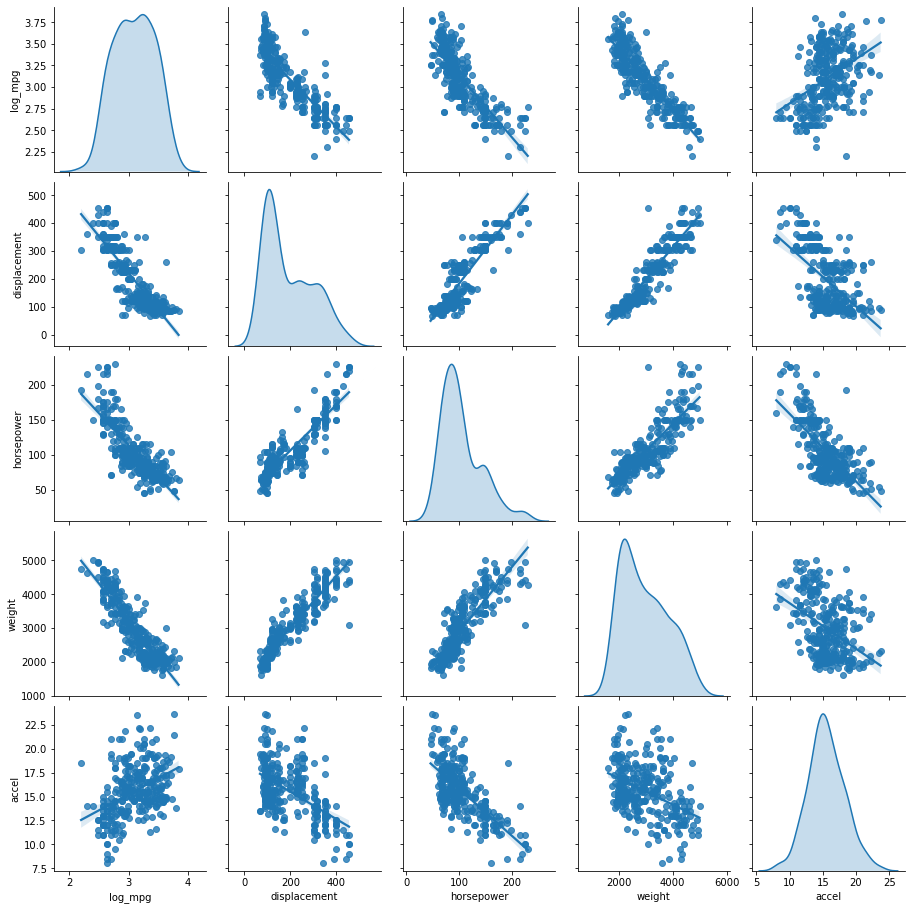

In [4]:
train_dataset = X_train.copy()
train_dataset.insert(0, "log_mpg", np.log(y_train))

sns.pairplot(train_dataset[['log_mpg','displacement','horsepower','weight','accel']], kind='reg', diag_kind='kde')

## Part B: Data Preprocessing & Pipeline

Let's label our numerical and categorical columns:

In [5]:
categorical_columns = ['cylinders','origin','year']
numerical_columns = ['displacement','horsepower','weight','accel']

And here's our first major change.

We're going to add Polynomial Features into our preprocessor, which takes our continuous numerical columns and generates polynomial versions.

Our pipeline now requires multiple steps for continuous columns, so let's get to work! It's going to be a little more involved.

Our numerical transformer now requires two steps:

1. Generate Polynomial Features
2. Standard Scale Features

Let's get right too it!

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

numerical_transformer = Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)),
                                        ('scaler', StandardScaler())])

A few considerations here. We have `interaction_only=True` because we want to analyze the interaction terms like $weight * acceleration$, and don't really care about terms like $weight^2$. We also needed to give our steps names!

Now, we can define our transformer for one hot encoding variables:

In [7]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

And now we can combine both of them to form our column transformer for preprocessing!

In [8]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

And now we can build our Ridge model:

In [9]:
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=0.2442053094548655),
        func = np.log,
        inverse_func = np.exp
    )
)

Fitting the model is exactly the same!

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['

And generating predictions is the same:

In [11]:
y_pred_in = model.predict(X_train)

**Bonus Box Time**

When we build a model, we get a text pipeline, however, we can make an html output that's interactive:

In [12]:
from sklearn import set_config

set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=0.2442053094548655)))])

## Part C: Evaluating Ridge Model

Let's bring back the metrics we've been looking at:

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_score(y_train, y_pred_in)
mean_squared_error(y_train, y_pred_in)
mean_absolute_error(y_train, y_pred_in)

0.9061887164615768

5.807284805619755

1.6713020747457639

And now let's plot our predictions and residuals as we've previously done:

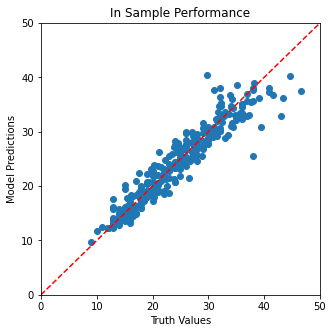

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_train, y_pred_in)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("In Sample Performance")
plt.show();

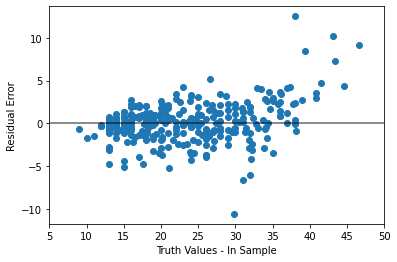

In [15]:
plt.scatter(y_train, y_train-y_pred_in)
plt.xlabel("Truth Values - In Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

Our model is now more centered, even though we're missing some high end mpg cars! (This may be something we cannot explain with these input variables).

Let's get a look at the coefficients from the model. Now, we need to grab both the categorical and numerical feature names from the preprocessor.

Getting the names out of the numerical processor is a small trip:

In [16]:
model.named_steps['columntransformer'].named_transformers_['num'].steps[0][1].get_feature_names(input_features=numerical_columns)

['displacement',
 'horsepower',
 'weight',
 'accel',
 'displacement horsepower',
 'displacement weight',
 'displacement accel',
 'horsepower weight',
 'horsepower accel',
 'weight accel',
 'displacement horsepower weight',
 'displacement horsepower accel',
 'displacement weight accel',
 'horsepower weight accel']

And we can also pull out the categorical labels:

In [17]:
model.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names(input_features=categorical_columns)

array(['cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6',
       'cylinders_8', 'origin_1', 'origin_2', 'origin_3', 'year_70',
       'year_71', 'year_72', 'year_73', 'year_74', 'year_75', 'year_76',
       'year_77', 'year_78', 'year_79', 'year_80', 'year_81', 'year_82'],
      dtype=object)

Now, let's assemble our column names. A big change is our order! Now we're doing continuous numerical columns first! (order matters!!)

In [18]:
numerical_names = model.named_steps['columntransformer'].named_transformers_['num'].steps[0][1].get_feature_names(input_features=numerical_columns)

categorical_names = model.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names(input_features=categorical_columns)

feature_names = np.concatenate([numerical_names, categorical_names])
feature_names

array(['displacement', 'horsepower', 'weight', 'accel',
       'displacement horsepower', 'displacement weight',
       'displacement accel', 'horsepower weight', 'horsepower accel',
       'weight accel', 'displacement horsepower weight',
       'displacement horsepower accel', 'displacement weight accel',
       'horsepower weight accel', 'cylinders_3', 'cylinders_4',
       'cylinders_5', 'cylinders_6', 'cylinders_8', 'origin_1',
       'origin_2', 'origin_3', 'year_70', 'year_71', 'year_72', 'year_73',
       'year_74', 'year_75', 'year_76', 'year_77', 'year_78', 'year_79',
       'year_80', 'year_81', 'year_82'], dtype=object)

And now let's extract our coefficients!

It's the same as before.

In [19]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['coef'], index=feature_names
)

coefs.head()

,coef
displacement,-0.236925
horsepower,0.069555
weight,-0.121549
accel,0.038815
displacement horsepower,-0.066949


Let's plot the coefficients:

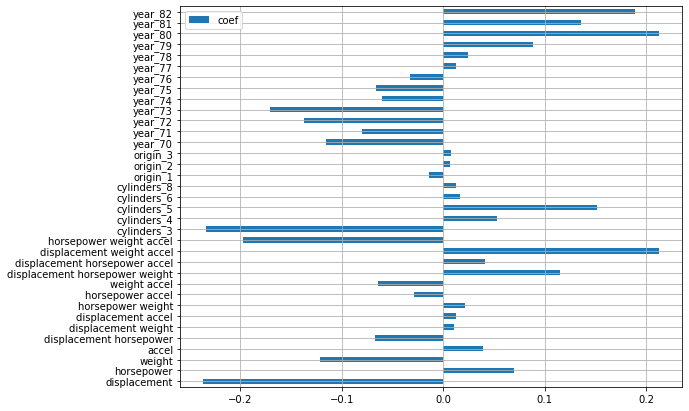

In [20]:
coefs.plot(kind='barh', figsize=(9,7), grid=True)

You can now see that the polynomial variables have taken a signifiant amount of the weights!

If you know your physics relationships or are a car person, some of these should be making sense!

Now, this is where I got the alpha parameter from:

In [21]:
from sklearn.linear_model import RidgeCV

ridge_cv = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10,10,50)),
        func = np.log,
        inverse_func = np.exp
    )
)

ridge_cv.fit(X_train, y_train)

ridge_cv[-1].regressor_.alpha_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetre...
       6.25055193e-01, 1.59985872e+00, 4.09491506e+00, 1.04811313e+01,
       2.68269580e+01, 6.86648845e+01, 1.75751062e+02, 4.49843267e+02,
       1.15139540e+03, 2.94705170e+03, 7.54312006e+03, 1.93069773e+04,
       4.94171336e+04, 1.26485522e+05, 3.23745754e+05, 8.28642773e+05,
       2.12095089e+06, 5.42867544e+06, 1.38949549e+07, 3.55648031e+07,
       9.10298178e+07, 2.32995181e+08, 5.96362332e+08, 1.52641797e+09,
       3.90693994e+09, 1.00000000e+10]))))])

0.2442053094548655

And now let's run our CV to test if our results are dependent upon sampling:

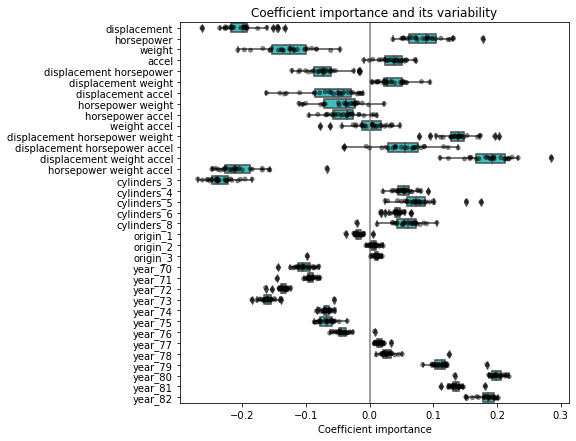

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

cv_coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ for est in cv_model['estimator']],
    columns=feature_names)

plt.figure(figsize=(9,7))
sns.stripplot(data=cv_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=cv_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)
plt.show();

We're seeing a little more variation within the polynomial terms, however, that's fine as those are most likely colinear in nature, and some runs of the models are simply going to shift weights between them.

Let's now analyze some out of sample metrics:

In [23]:
y_pred_out = model.predict(X_test)

In [24]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, y_pred_in), mean_squared_error(y_train, y_pred_in), mean_absolute_error(y_train, y_pred_in))
metrics['out'] = (r2_score(y_test, y_pred_out), mean_squared_error(y_test, y_pred_out), mean_absolute_error(y_test, y_pred_out))

metrics

,in,out
r2,0.906189,0.896274
mse,5.807285,6.007383
mae,1.671302,1.870646


We're now at 0.896 $r^2$ when out of sample! This is an increase from 0.854 from just a basic linear regression!

Let's look at our out of sample graphs:

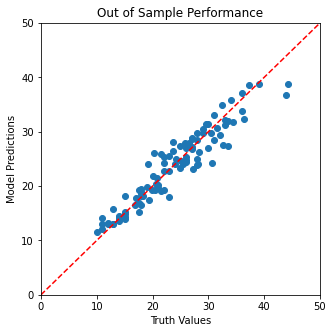

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_test, y_pred_out)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("Out of Sample Performance")
plt.show();

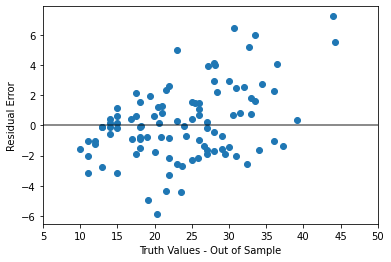

In [26]:
plt.scatter(y_test, y_test-y_pred_out)
plt.xlabel("Truth Values - Out of Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

We're doing really well! However, we definitely introduced more complexity into our models.

A similar ML model can help us with this. The one I want to introduce is LASSO, which has a slightly different penalty. This one uses an L1 penalty that can reduce coefficients to zero! 

Read more about it here: https://www.statisticshowto.com/lasso-regression/

I'm going to go through this one quickly as a bonus box.

Backwards, I'm actually going to extract the alpha parameter first:

In [27]:
from sklearn.linear_model import LassoCV

lasso_cv = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=np.logspace(-10,10,50), max_iter=1000000),
        func = np.log,
        inverse_func = np.exp
    )
)

lasso_cv.fit(X_train, y_train)
lasso_cv[-1].regressor_.alpha_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetre...
       2.68269580e+01, 6.86648845e+01, 1.75751062e+02, 4.49843267e+02,
       1.15139540e+03, 2.94705170e+03, 7.54312006e+03, 1.93069773e+04,
       4.94171336e+04, 1.26485522e+05, 3.23745754e+05, 8.28642773e+05,
       2.12095089e+06, 5.42867544e+06, 1.38949549e+07, 3.55648031e+07,
       9.10298178e+07, 2.32995181e+08, 5.96362332e+08, 1.52641797e+09,
       3.90693994e+09, 1.00000000e+10]),
                                                              max_iter=1000000)))])

0.0001325711365590111

And now let's run the LASSO regression with our alpha parameter:

In [28]:
from sklearn.linear_model import Lasso

lasso = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=0.0001325711365590111, max_iter=100000),
        func = np.log,
        inverse_func = np.exp
    )
)

lasso.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Lasso(alpha=0.0001325711365590111,
                                                            max_iter=100000)))])

I'm now going to paste the code for the similar pattern we've been doing previously.

Generate predictions with the model:

In [29]:
lasso_pred_in = lasso.predict(X_train)

Calculate our in sample metrics:

In [30]:
r2_score(y_train, lasso_pred_in)
mean_squared_error(y_train, lasso_pred_in)
mean_absolute_error(y_train, lasso_pred_in)

0.9060492154025674

5.815920465956084

1.6623452576068651

And now plot our residual plots:

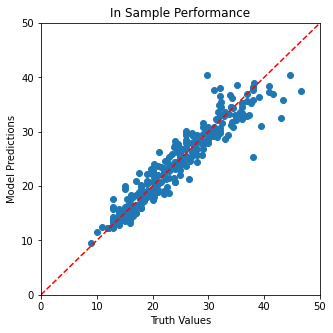

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_train, lasso_pred_in)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("In Sample Performance")
plt.show();

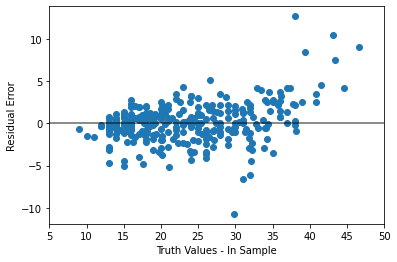

In [32]:
plt.scatter(y_train, y_train-lasso_pred_in)
plt.xlabel("Truth Values - In Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

Now, let's look at the coefficients our model fit.

Lots of them are now zero. A large benefit of LASSO vs Ridge is a simpler model that is easier to explain. (Explanability is a huge component of ML).

In [33]:
coefs = pd.DataFrame(
    lasso.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['coef'], index=feature_names
)

coefs

,coef
displacement,-0.270470
horsepower,0.042707
weight,-0.116217
accel,0.024924
displacement horsepower,0.000000
displacement weight,-0.000000
displacement accel,0.000000
horsepower weight,0.000000
horsepower accel,0.000000
weight accel,-0.059416


And we can plot our coefficients:

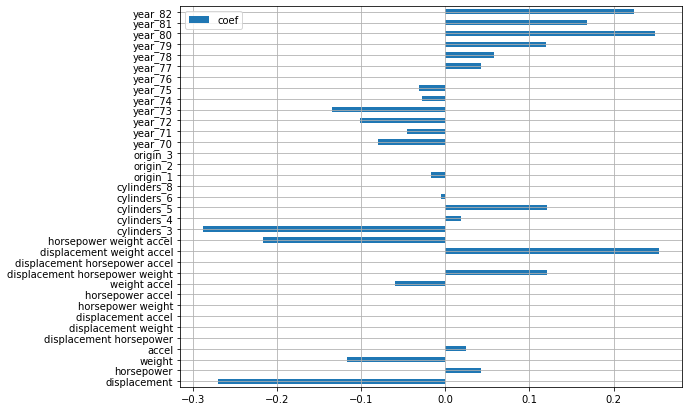

In [34]:
coefs.plot(kind='barh', figsize=(9,7), grid=True)

And before we gauge out of sample performance, we can analyze our LASSO across folds:

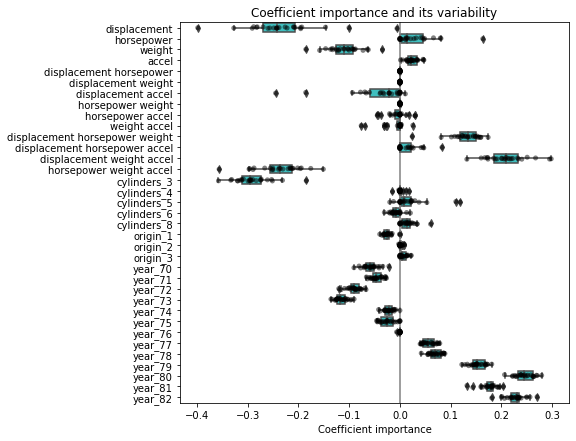

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    lasso, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

cv_coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ for est in cv_model['estimator']],
    columns=feature_names)

plt.figure(figsize=(9,7))
sns.stripplot(data=cv_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=cv_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)
plt.show();

Why does LASSO inherently have a larger coefficient spread across folds:

- Instead of trying to find the best coefficient every time, the'll sometimes be pushed to zero.
- Since a lot of the polynomial term covary, we see some times they are set to zero, and other times have weight on them
- A really good sign is that our categorical features have a small spread, and are pretty stable!

Let's now get into our holdout performance:

In [36]:
lasso_pred_out = lasso.predict(X_test)

Our metric DataFrame that you've seen a lot before:

In [37]:
metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, lasso_pred_in), mean_squared_error(y_train, lasso_pred_in), mean_absolute_error(y_train, lasso_pred_in))
metrics['out'] = (r2_score(y_test, lasso_pred_out), mean_squared_error(y_test, lasso_pred_out), mean_absolute_error(y_test, lasso_pred_out))

metrics

,in,out
r2,0.906049,0.895259
mse,5.815920,6.066166
mae,1.662345,1.873895


We're explaning practically the same amount, however, we now have a much simpler model!

Simpler models are often preferred, as they are less likely to overfit the dataset we're working with, and can use them to predict data that we may never have a validation data point for!

They're also easier to explain, and in the workplace, the *blackbox* theory will not always be justifiable-especially when something has gone wrong.

## Summary Time

**NB1:** For linear regression in SciKit Learn, we started with just a basic linear regression!

- We dropped out the first occurence of a categorical variable, which meant that we could not run into any new categories during testing and validation of the model. However, this prevented us from introducing colinearity into the model.

- The model had decent performance, with an $r^2$ of about 0.854, however, the residual errors definitly had a curved pattern in them.

- For the purposes of the dataset, making predictions based upon the model is pretty good! However, some of the trend near the edges (low / high mpg) information was being lost.

**NB2:** To make some of the curved residuals go away, we took the natural log of mpg, which made the distribution look much closer to normal.

- This time, we dropped out the last occurence of a categorical variable, and set the pipeline to ignore unknowns by setting the one-hot encoding to all zeroes. This meant any new labels we found in testing or validation sets would be coerced to the value of the dropped. Thankfully, this only occured once every 25 folds during cross validation, and is something that should not impact the model much at all.

- To get around this, we could manually build the distribution of coefficients to plot sensitivity, however, the work hardly changes results, but makes coding much more challenging. (The change is something around 1/10000 for this dataset, but your mileage may vary in different datasets).

- The model had even better performance when taking the natural logarithm of mpg, with an $r^2$ of 0.880. Most of the curved residuals also reduced, being only slighly visible on the top end.

**NB3:** Since we were technically suppressing errors into the dropped continuous category, I introduced Ridge regression, which introduces an L2 penalty to reduce complexity and introduce some smoothing to the model. Since Ridge models can handle colinearity, we no longer have to drop out a one-hot encoded variable, and mismatches can be coded as all zeroes.

- To make coefficients easy to compare right away, we scaled all the inputs using SKLearn's `StandardScaler()` function, which standardizes by removing the mean and scaling to unit variance, very similar to a z score.

- The $r^2$ value dropped slightly duirng the first Ridge regression to 0.879. However, the model is a better "fit" as there's some smoothing occuring, and there is a much better balance between coefficients visible in the graphs. The previous models put too much emphasis on weight, and did not account for the other regressors as well (potentially because they're all related and vary together with mpg.)

- The best part so far about the Ridge model is the ability to fix the colinearlity, and no longer worry about encoding new values in our test/validation datasets.

- However, this ridge model still missed out on the curve for high mpg cars, something we try to fix next with both Ridge and LASSO by introducing polynomial features.

**NB4:** To account for the nonlinear and dependent relationships between weight, acceleration, displacement, and horsepower, I introduced the Polynomial Features into the dataset. I was only interested in the interaction features up to the 3rd degree, and not the units themselves squared/cubed. ($x_1 * x_2$ was included, but not $x_1^2$)

- Since we needed both polynomial features and standard scaling, I introduced a more complex pipeline with multiple steps. While it's more complex, it builds upon what we've already seen in previous notebooks.

- Including the polynomial terms to the third power increased the $r^2$ of the model to 0.897 with Ridge! It also removed almost all of the curve to the residual plot. This model so far has been the best one we trained! Unfortunately, at this point, the residuals at the high mpg end may not be explanable with our variables. However, the model was much tighter bound to the prediction lines.

- However, our model became more complex and added more coefficients into the mix. To fix this, I introduced a LASSO regression which includes a complexity penalty, and can set regressor coefficients to zero! LASSO is good because it simplifies the model and is easy to explain!

- The LASSO regression set 9/35 coefficients to zero, reducing the complexity! The explanatory power stayed nearly the same (and is probably less likely to be overfit) with an $r^2$ of 0.895.

Overall, the methods you've learned in these notebooks should serve as a great entry to analyzing regression problems in real world data. And the good thing is that these methods are only slight changes and manipulations to OLS! Future methods may not be as easy to "explain" or visualize.